In [1]:
from implementations import *
from proj1_helpers import *

import numpy as np
import random
from tqdm import tqdm_notebook

%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
LOWER_BOUND = -1
UPPER_BOUND = 1

# Import data

In [4]:
DATA_FOLDER = "competition-data/"
DATA_TEST = "test.csv"
DATA_TRAIN = "train.csv"

y_train, x_train, ids_train = load_csv_data(DATA_FOLDER + DATA_TRAIN, LOWER_BOUND, UPPER_BOUND)
y_test, x_test, ids_test = load_csv_data(DATA_FOLDER + DATA_TEST, LOWER_BOUND, UPPER_BOUND)

In [5]:
tx_train = x_train.T
tx_test = x_test.T

In [6]:
tx_train

array([[ 138.47 ,  160.937,      nan, ...,  105.457,   94.951,      nan],
       [  51.655,   68.768,  162.172, ...,   60.526,   19.362,   72.756],
       [  97.827,  103.235,  125.953, ...,   75.839,   68.812,   70.831],
       ..., 
       [   1.24 ,      nan,      nan, ...,      nan,      nan,      nan],
       [  -2.475,      nan,      nan, ...,      nan,      nan,      nan],
       [ 113.497,   46.226,   44.251, ...,   41.992,    0.   ,    0.   ]])

# Cleaning data

In [7]:
tx_train, idx_to_del = delete_features(tx_train, 0.7)
tx_test = delete_features_from_idx(tx_test, idx_to_del)
tx_train.shape
tx_test.shape

(23, 568238)

In [8]:
print(idx_to_del)

[4, 5, 6, 12, 26, 27, 28]


In [9]:
tx_train = replace_nan_by_median(tx_train)
tx_test = replace_nan_by_median(tx_test)

In [10]:
mean_train, std_train, tx_train = standardize(tx_train)
tx_test = standardize_predef(tx_test, mean_train, std_train)

In [82]:
#tx_train = min_max(tx_train)

In [83]:
tx_train, y_train = balance(tx_train.T, y_train, LOWER_BOUND, UPPER_BOUND)

In [11]:
tx_train
tx_train.shape

(23, 250000)

# Cross Validation for Ridge Regression

In [12]:
model = "ridge_regression"
seed = 3
k_fold = 10
k_indices = build_k_indices(y_train, k_fold, seed)
degrees = np.arange(1, 13, 1)
lambdas = np.logspace(-4, -1, 10)
gammas = [0]
max_iters = 0

def cross_validation_demo(model, k_fold, k_indices, degrees, lambdas, gammas, max_iters, tx_train, y_train):
    results = []
    for degree in tqdm_notebook(degrees):
        tx_poly = build_poly_tx(tx_train, degree)
        initial_w = init_w(tx_poly)
        for gamma in gammas:
            for lambda_ in lambdas:
                accs = []
                ws = []
                for k in range(k_fold):
                    w_tr, acc = cross_validation(y_train, tx_poly.T, initial_w,
                                                 max_iters,  k_indices, k, gamma, lambda_, LOWER_BOUND, UPPER_BOUND, model)
                    ws.append(w_tr)
                    accs.append(acc)
                w_final = np.mean(ws, axis=0)
                acc_mean = np.mean(accs)
                results.append((degree, gamma, lambda_, acc_mean))

                print("Finished: " + str((degree, gamma, lambda_, acc_mean)))
    
    print(results)
    
    best_degree, best_gamma, best_lambda, best_acc_mean = max(results, key=lambda x: x[3])
    print("Best accuracy: ",best_acc_mean)
    print("Best degree: ", best_degree)
    print("Best gamma: ", best_gamma)
    print("Best lambda: ", best_lambda)
    
    return results

results = cross_validation_demo(model, k_fold, k_indices, degrees, lambdas, gammas, max_iters, tx_train, y_train)

Finished: (1, 0, 0.0001, 0.7338039999999999)
Finished: (1, 0, 0.00021544346900318845, 0.73377600000000009)
Finished: (1, 0, 0.00046415888336127773, 0.73373199999999994)
Finished: (1, 0, 0.001, 0.73372800000000005)
Finished: (1, 0, 0.0021544346900318821, 0.73361999999999994)
Finished: (1, 0, 0.0046415888336127772, 0.73359200000000002)
Finished: (1, 0, 0.01, 0.73314799999999991)
Finished: (1, 0, 0.021544346900318822, 0.73220400000000008)
Finished: (1, 0, 0.046415888336127774, 0.72988799999999998)
Finished: (1, 0, 0.10000000000000001, 0.72628800000000004)
Finished: (2, 0, 0.0001, 0.7656639999999999)
Finished: (2, 0, 0.00021544346900318845, 0.76570799999999983)
Finished: (2, 0, 0.00046415888336127773, 0.76570000000000005)
Finished: (2, 0, 0.001, 0.76567599999999991)
Finished: (2, 0, 0.0021544346900318821, 0.76539200000000007)
Finished: (2, 0, 0.0046415888336127772, 0.76514800000000005)
Finished: (2, 0, 0.01, 0.76461999999999997)
Finished: (2, 0, 0.021544346900318822, 0.76370800000000005)
F

In [25]:
results

[(1, 0.7, 0, 0.75813200000000003)]

# Performance

/Users/Joel/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:4243: RuntimeWarning: divide by zero encountered in double_scalars
  sy = (ymax - ymin) / ny
/Users/Joel/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:4346: RuntimeWarning: invalid value encountered in multiply
  offsets[:, 1] *= sy


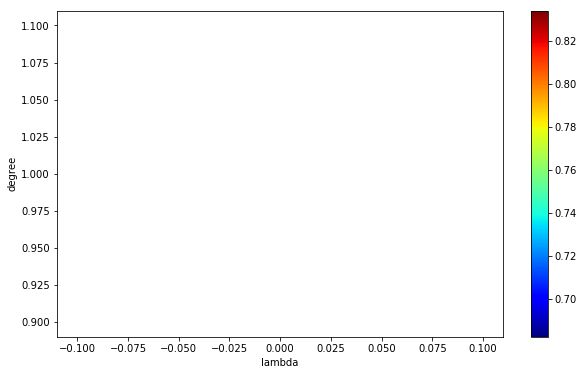

In [23]:
import pandas as pd

# show the best results for different parameters of the ridge regression
def show_ridge_results(results, l_degrees):

    df = pd.DataFrame.from_records(results, columns=['degree', 'gamma', 'lambda', 'acc'])
    df.plot.hexbin(x='lambda', y='degree', C='acc', gridsize=l_degrees, figsize=(10,6), sharex=False, cmap='jet')
    plt.show()
    
    return df
    
df = show_ridge_results(results, len(degrees))

# Selecting best parameters

In [14]:
def compute_raw_predictions(results, degrees, tx, y):
    y_raw_preds = []
    ws = []
    for d in degrees:
        r_d = [r for r in results if r[0] == d]
        degree, gamma, lambda_, acc_mean = max(r_d, key=lambda x: x[3])
        tx_poly = build_poly_tx(tx, d)
        w, l = ridge_regression(y, tx_poly, lambda_)
        ws.append(w)
        y_raw_pred = np.dot(tx_poly.T, np.array(w))
        y_raw_preds.append(y_raw_pred)
        
    return y_raw_preds, ws

y_raw_preds, ws = compute_raw_predictions(results, [9, 10, 11], tx_train, y_train)
y_raw_preds

[array([[ 0.13681128],
        [-0.09585492],
        [ 0.03103595],
        ..., 
        [-0.34341299],
        [-0.06824147],
        [-0.49605018]]), array([[ 0.1332059 ],
        [-0.097928  ],
        [ 0.05540158],
        ..., 
        [-0.31900422],
        [-0.05139256],
        [-0.49016231]]), array([[ 0.14684682],
        [-0.0766211 ],
        [-0.02604242],
        ..., 
        [-0.34806072],
        [-0.07771574],
        [-0.48895453]])]

In [15]:
y_raw_preds_mean = np.mean(y_raw_preds, axis=0)
y_raw_preds_mean

array([[ 0.13895467],
       [-0.09013467],
       [ 0.0201317 ],
       ..., 
       [-0.33682598],
       [-0.06578326],
       [-0.49172234]])

In [16]:
threshold = (UPPER_BOUND + LOWER_BOUND)/2
y_raw_preds_mean[np.where(y_raw_preds_mean <= threshold)] = -1
y_raw_preds_mean[np.where(y_raw_preds_mean > threshold)] = 1
print(y_raw_preds_mean)

[[ 1.]
 [-1.]
 [ 1.]
 ..., 
 [-1.]
 [-1.]
 [-1.]]


In [17]:
np.mean(y_train == y_raw_preds_mean)

0.81234799999999996

In [132]:
y_train

array([[ 1.],
       [ 1.],
       [ 1.],
       ..., 
       [-1.],
       [-1.],
       [-1.]])

In [19]:
tx = np.squeeze(y_raw_preds, axis=2)
tx

array([[ 0.13681128, -0.09585492,  0.03103595, ..., -0.34341299,
        -0.06824147, -0.49605018],
       [ 0.1332059 , -0.097928  ,  0.05540158, ..., -0.31900422,
        -0.05139256, -0.49016231],
       [ 0.14684682, -0.0766211 , -0.02604242, ..., -0.34806072,
        -0.07771574, -0.48895453]])

In [20]:
w, l = least_squares(y_train, tx)

y_t = np.dot(tx.T, w)

np.mean(y_train == y_raw_preds_mean)

0.81234799999999996

In [21]:
model = "logistic_regression"
seed = 3
k_fold = 4
k_indices = build_k_indices(y_train, k_fold, seed)
degrees = [1]
lambdas = [0]
gammas = [0.7]
max_iters = 1000

def cross_validation_demo(model, k_fold, k_indices, degrees, lambdas, gammas, max_iters, tx_train, y_train):
    results = []
    for degree in tqdm_notebook(degrees):
        tx_poly = build_poly_tx(tx_train, degree)
        initial_w = init_w(tx_poly)
        for gamma in gammas:
            for lambda_ in lambdas:
                accs = []
                ws = []
                for k in range(k_fold):
                    w_tr, acc = cross_validation(y_train, tx_poly.T, initial_w,
                                                 max_iters,  k_indices, k, gamma, lambda_, LOWER_BOUND, UPPER_BOUND, model)
                    ws.append(w_tr)
                    accs.append(acc)
                w_final = np.mean(ws, axis=0)
                acc_mean = np.mean(accs)
                results.append((degree, gamma, lambda_, acc_mean))

                print("Finished: " + str((degree, gamma, lambda_, acc_mean)))
    
    print(results)
    
    best_degree, best_gamma, best_lambda, best_acc_mean = max(results, key=lambda x: x[3])
    print("Best accuracy: ",best_acc_mean)
    print("Best degree: ", best_degree)
    print("Best gamma: ", best_gamma)
    print("Best lambda: ", best_lambda)
    
    return results

results = cross_validation_demo(model, k_fold, k_indices, degrees, lambdas, gammas, max_iters, tx, y_train)

/Users/Joel/Drive/EPFL/MA1/github/CS-433/project1/implementations.py:125: RuntimeWarning: overflow encountered in exp
  exp_ = np.exp(tx.dot(w))
/Users/Joel/Drive/EPFL/MA1/github/CS-433/project1/implementations.py:118: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-t))


Finished: (1, 0.7, 0, 0.75813200000000003)

[(1, 0.7, 0, 0.75813200000000003)]
Best accuracy:  0.758132
Best degree:  1
Best gamma:  0.7
Best lambda:  0


# Predict labels

In [35]:
from proj1_helpers import predict_labels_kaggle

In [46]:
y_pred = predict_labels_kaggle(w_final, tx_test.T, LOWER_BOUND, UPPER_BOUND)

# Submission

In [47]:
from proj1_helpers import create_csv_submission

In [48]:
create_csv_submission(ids_test, y_pred, "test11.csv")

Test n : algorithm / features / y / w
- - - - - - - - - - - - - - - - - - - 
Test 1 : least_squares / all features standardized / y = -1,1 / random init_w

Test 2 : least_squares / corr > 0.1 features standardized / y = -1,1 / random init_w

Test 3 : least_squares_GD(10000,0.5) / all features standardized / y = -1,1 / random init_w

Test 4 : least_squares_GD(10000,0.5) / all features standardized / y = -1,1 / random init_w / poly, degree=1

Test 5 : least_squares / all features standardized / y = -1,1 / random init_w / median + categorical

Test 6 : logistic_regressoin  /all features standardized / y = 0,1 / random init_w / median + categorical + balanced

Test 7 : least_squares / all features standardized / y = 0,1 / random init_w

Test 8 : Test 1

Test 9 : Test 1

Test 10 : Test 1 / standardized test_set with mean and std from train_set

Test 11 : Test 1 / standardized test_set with mean and std from train_set / balance

## Further work

- balance output (batch numpy)
- median and category
- features engineering : features d'intéraction
- logistic regression 